In [10]:
import requests
API_KEY = '3ORMUAPSOIY1YU7J'

ticker = 'BHP'
tickers_peers = [ticker, "RIO", "VALE", "TECK", "MP"]


def get_company_overview(ticker, api_key):
    url = f"https://www.alphavantage.co/query?function=OVERVIEW&symbol={ticker}&apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error al obtener datos de {ticker}")
        return None


In [11]:
overview = get_company_overview(ticker, API_KEY)

In [12]:
def safe_float(value):
    try:
        return float(value)
    except (ValueError, TypeError):
        return float("nan")  # Devuelve NaN si no es convertible

In [13]:
def extract_key_multiples(data):
    return {
        "Ticker": data.get("Symbol"),
        "P/E": safe_float(data.get("PERatio")),
        "EV/EBITDA": safe_float(data.get("EVToEBITDA")),
        "EV/Revenue": safe_float(data.get("EVToRevenue")),
        "P/B": safe_float(data.get("PriceToBookRatio")),
        "P/S": safe_float(data.get("PriceToSalesRatioTTM")),
        "MarketCap": safe_float(data.get("MarketCapitalization")),
        "EBITDA": safe_float(data.get("EBITDA")),
        "RevenueTTM": safe_float(data.get("RevenueTTM")),
    }

In [14]:
import pandas as pd

results = []

for t in tickers_peers:
    data = get_company_overview(t, API_KEY)
    if data:
        multiples = extract_key_multiples(data)
        results.append(multiples)

df_multiples = pd.DataFrame(results)
df_multiples.set_index("Ticker", inplace=True)
df_multiples


,P/E,EV/EBITDA,EV/Revenue,P/B,P/S,MarketCap,EBITDA,RevenueTTM
Ticker,,,,,,,,
BHP,10.43,4.601,2.407,2.606,2.204,1.189650e+11,2.582900e+10,5.397100e+10
RIO,8.02,4.271,1.844,1.668,1.717,9.213447e+10,1.905700e+10,5.365800e+10
VALE,6.57,4.891,1.426,1.099,0.186,3.924901e+10,7.403000e+10,2.115250e+11
TECK,765.00,11.800,3.066,1.013,1.955,1.903660e+10,3.192000e+09,9.735999e+09
MP,NaN,68.380,27.520,5.580,26.790,5.786342e+09,-8.468400e+07,2.159810e+08


In [15]:
empresa_objetivo = df_multiples.loc[ticker]
comparables = df_multiples.drop(ticker)

benchmark_avg = comparables.mean(numeric_only=True)
benchmark_median = comparables.median(numeric_only=True)

comparacion = pd.DataFrame({
    "Empresa Objetivo (MSFT)": empresa_objetivo,
    "Promedio Comparables": benchmark_avg,
    "Mediana Comparables": benchmark_median,
    "Diferencia vs Promedio (%)": 100 * (empresa_objetivo - benchmark_avg) / benchmark_avg
})
comparacion


,Empresa Objetivo (MSFT),Promedio Comparables,Mediana Comparables,Diferencia vs Promedio (%)
P/E,1.043000e+01,2.598633e+02,8.020000e+00,-95.986352
EV/EBITDA,4.601000e+00,2.233550e+01,8.345500e+00,-79.400506
EV/Revenue,2.407000e+00,8.464000e+00,2.455000e+00,-71.561909
P/B,2.606000e+00,2.340000e+00,1.383500e+00,11.367521
P/S,2.204000e+00,7.662000e+00,1.836000e+00,-71.234665
MarketCap,1.189650e+11,3.905161e+10,2.914281e+10,204.635345
EBITDA,2.582900e+10,2.404858e+10,1.112450e+10,7.403433
RevenueTTM,5.397100e+10,6.878374e+10,3.169700e+10,-21.535237


In [16]:
ebitda_empresa = empresa_objetivo["EBITDA"]
ev_ebitda_benchmark = benchmark_median["EV/EBITDA"]

# Estimación del valor de empresa (Enterprise Value)
ev_estimado = ebitda_empresa * ev_ebitda_benchmark

# Valor estimado por acción (si conoces shares)
market_cap_estimado = ev_estimado  # aprox si deuda neta es baja
precio_accion_estimado = market_cap_estimado / (empresa_objetivo["MarketCap"] / empresa_objetivo["P/E"])  # aprox


In [17]:
def estimar_valor_por_multiplo(emp, bench, tipo='mediana'):
    estimaciones = {}

    # Precio/Utilidad
    if emp["P/E"] > 0 and bench["P/E"] > 0:
        utilidad = emp["MarketCap"] / emp["P/E"]
        estimaciones["P/E"] = utilidad * bench["P/E"]

    # EV/EBITDA
    if emp["EV/EBITDA"] > 0 and bench["EV/EBITDA"] > 0:
        estimaciones["EV/EBITDA"] = emp["EBITDA"] * bench["EV/EBITDA"]

    # EV/Revenue
    if emp["EV/Revenue"] > 0 and bench["EV/Revenue"] > 0:
        estimaciones["EV/Revenue"] = emp["RevenueTTM"] * bench["EV/Revenue"]

    # P/B
    if emp["P/B"] > 0 and bench["P/B"] > 0:
        book_value = emp["MarketCap"] / emp["P/B"]
        estimaciones["P/B"] = book_value * bench["P/B"]

    # P/S
    if emp["P/S"] > 0 and bench["P/S"] > 0:
        estimaciones["P/S"] = emp["RevenueTTM"] * bench["P/S"]

    return estimaciones


In [18]:
# Filtramos empresa objetivo y comparables
empresa_obj = df_multiples.loc[ticker]
comparables = df_multiples.drop(ticker)

# Benchmarks
benchmark_mean = comparables.mean(numeric_only=True)
benchmark_median = comparables.median(numeric_only=True)

# Estimar valores implícitos
valor_estimado_prom = estimar_valor_por_multiplo(empresa_obj, benchmark_mean, tipo='promedio')
valor_estimado_med = estimar_valor_por_multiplo(empresa_obj, benchmark_median, tipo='mediana')


In [19]:
estimaciones_df = pd.DataFrame({
    "Valor Estimado (Promedio)": valor_estimado_prom,
    "Valor Estimado (Mediana)": valor_estimado_med
})

# Agregamos Market Cap actual
estimaciones_df["Market Cap Actual"] = empresa_obj["MarketCap"]
estimaciones_df["Diferencia (%) (Mediana)"] = 100 * (estimaciones_df["Valor Estimado (Mediana)"] - empresa_obj["MarketCap"]) / empresa_obj["MarketCap"]
estimaciones_df["Diferencia (%) (Promedio)"] = 100 * (estimaciones_df["Valor Estimado (Promedio)"] - empresa_obj["MarketCap"]) / empresa_obj["MarketCap"]

estimaciones_df


,Valor Estimado (Promedio),Valor Estimado (Mediana),Market Cap Actual,Diferencia (%) (Mediana),Diferencia (%) (Promedio)
P/E,2.964011e+12,9.147644e+10,1.189650e+11,-23.106424,2391.498881
EV/EBITDA,5.769036e+11,2.155559e+11,1.189650e+11,81.192722,384.935600
EV/Revenue,4.568106e+11,1.324988e+11,1.189650e+11,11.376299,283.987371
P/B,1.068220e+11,6.315736e+10,1.189650e+11,-46.910975,-10.207214
P/S,4.135258e+11,9.909076e+10,1.189650e+11,-16.705953,247.602934


In [20]:
def get_shares_outstanding(info):
    try:
        pe = float(info.get("PERatio", "nan"))
        eps = float(info.get("EPS", "nan"))
        market_cap = float(info.get("MarketCapitalization", "nan"))
        if pe > 0 and eps > 0:
            return market_cap / (pe * eps)
        else:
            return float("nan")
    except:
        return float("nan")


In [21]:
shares_outstanding = get_shares_outstanding(overview)

In [22]:
precios_estimados = estimaciones_df.copy()

# Calcula el precio por acción estimado
precios_estimados["Precio Acción (Promedio)"] = precios_estimados["Valor Estimado (Promedio)"] / shares_outstanding
precios_estimados["Precio Acción (Mediana)"] = precios_estimados["Valor Estimado (Mediana)"] / shares_outstanding

# Precio actual de la acción
precio_actual = empresa_obj["MarketCap"] / shares_outstanding
precios_estimados["Precio Actual Acción"] = precio_actual

# Diferencia en %
precios_estimados["Diferencia % (Mediana)"] = 100 * (precios_estimados["Precio Acción (Mediana)"] - precio_actual) / precio_actual
precios_estimados["Diferencia % (Promedio)"] = 100 * (precios_estimados["Precio Acción (Promedio)"] - precio_actual) / precio_actual

# Mostrar
precios_estimados[
    ["Precio Acción (Mediana)", "Precio Acción (Promedio)", "Precio Actual Acción", "Diferencia % (Mediana)", "Diferencia % (Promedio)"]
]


,Precio Acción (Mediana),Precio Acción (Promedio),Precio Actual Acción,Diferencia % (Mediana),Diferencia % (Promedio)
P/E,35.929600,1164.187733,46.7264,-23.106424,2391.498881
EV/EBITDA,84.664836,226.592948,46.7264,81.192722,384.935600
EV/Revenue,52.042135,179.423475,46.7264,11.376299,283.987371
P/B,24.806590,41.956936,46.7264,-46.910975,-10.207214
P/S,38.920310,162.422337,46.7264,-16.705953,247.602934


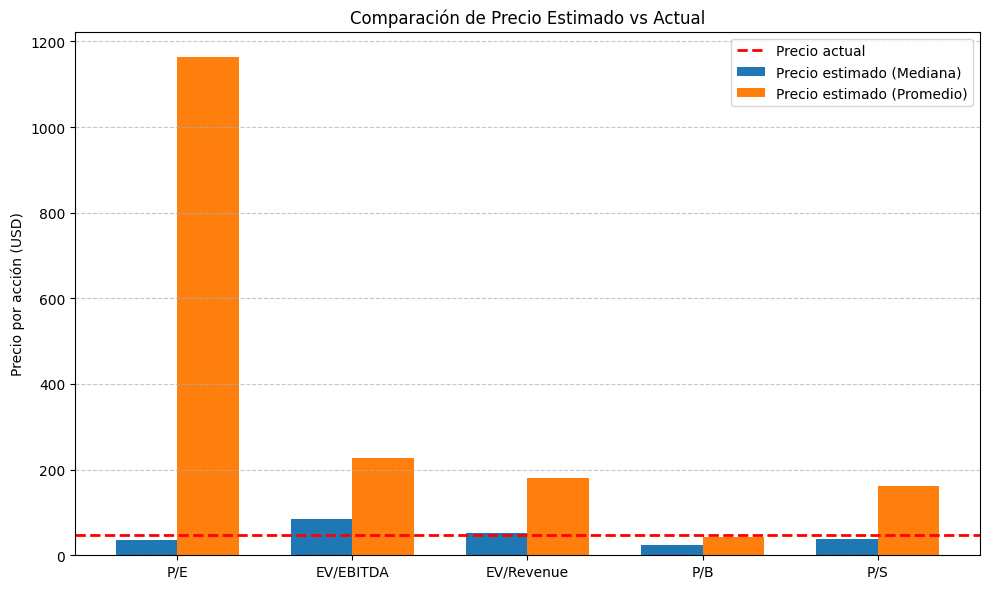

In [23]:
import matplotlib.pyplot as plt

# Filtramos solo los múltiplos con datos válidos
precios_plot = precios_estimados.dropna(subset=["Precio Acción (Mediana)", "Precio Acción (Promedio)"])

# Variables
multiples = precios_plot.index
precio_actual = precios_plot["Precio Actual Acción"].iloc[0]
precios_mediana = precios_plot["Precio Acción (Mediana)"]
precios_promedio = precios_plot["Precio Acción (Promedio)"]

# Crear gráfico
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(multiples))

# Barras de precios estimados
plt.bar(x, precios_mediana, width=bar_width, label="Precio estimado (Mediana)")
plt.bar([i + bar_width for i in x], precios_promedio, width=bar_width, label="Precio estimado (Promedio)")

# Línea de precio actual
plt.axhline(y=precio_actual, color='red', linestyle='--', linewidth=2, label="Precio actual")

# Etiquetas
plt.xticks([i + bar_width/2 for i in x], multiples)
plt.ylabel("Precio por acción (USD)")
plt.title("Comparación de Precio Estimado vs Actual")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [24]:
def promedio_ponderado_por_mcap(df, columna_multiplo, columna_mcap="MarketCap"):
    df_filtrado = df[[columna_multiplo, columna_mcap]].dropna()
    pesos = df_filtrado[columna_mcap] / df_filtrado[columna_mcap].sum()
    promedio_pond = (pesos * df_filtrado[columna_multiplo]).sum()
    return promedio_pond


In [25]:
multiplo_cols = ["P/E", "EV/EBITDA", "EV/Revenue", "P/B", "P/S"]

benchmark_ponderado = {}

for col in multiplo_cols:
    benchmark_ponderado[col] = promedio_ponderado_por_mcap(comparables, col)

benchmark_ponderado = pd.Series(benchmark_ponderado)
benchmark_ponderado.name = "Promedio Ponderado"
benchmark_ponderado

P/E           103.442216
EV/EBITDA       7.719114
EV/Revenue      2.839009
P/B             1.590119
P/S             2.290097
Name: Promedio Ponderado, dtype: float64

In [26]:
valor_estimado_ponderado = estimar_valor_por_multiplo(empresa_obj, benchmark_ponderado, tipo="ponderado")

df_val_ponderado = pd.DataFrame({
    "Valor Estimado (Ponderado)": valor_estimado_ponderado,
})

df_val_ponderado["Precio Acción (Ponderado)"] = df_val_ponderado["Valor Estimado (Ponderado)"] / shares_outstanding
df_val_ponderado["Precio Actual Acción"] = empresa_obj["MarketCap"] / shares_outstanding
df_val_ponderado["Diferencia %"] = 100 * (df_val_ponderado["Precio Acción (Ponderado)"] - df_val_ponderado["Precio Actual Acción"]) / df_val_ponderado["Precio Actual Acción"]

df_val_ponderado

,Valor Estimado (Ponderado),Precio Acción (Ponderado),Precio Actual Acción,Diferencia %
P/E,1.179866e+12,463.421127,46.7264,891.775799
EV/EBITDA,1.993770e+11,78.310171,46.7264,67.592991
EV/Revenue,1.532241e+11,60.182516,46.7264,28.797674
P/B,7.258961e+10,28.511336,46.7264,-38.982382
P/S,1.235988e+11,48.546451,46.7264,3.895123


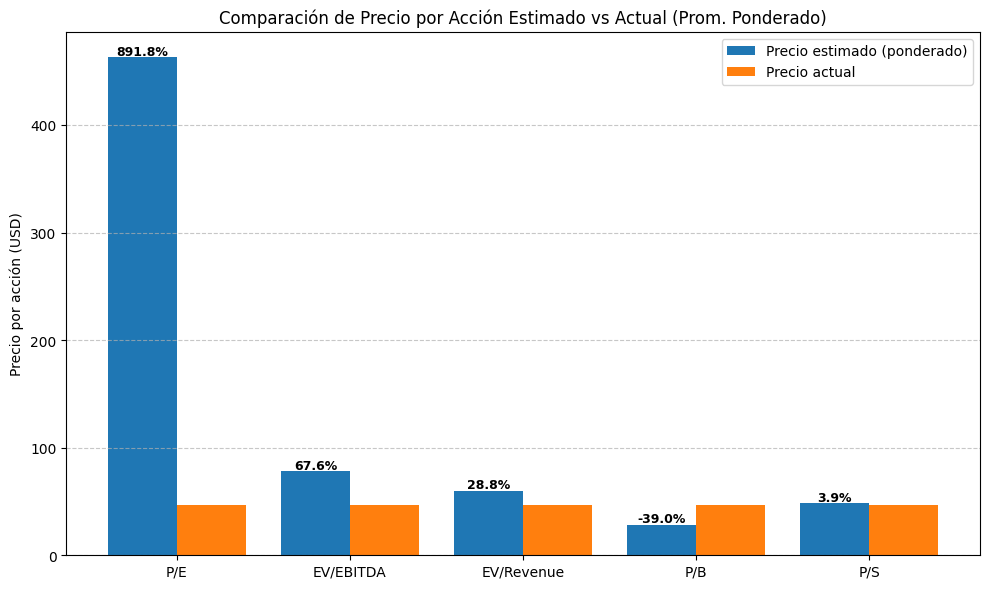

In [27]:
# Filtramos valores válidos
grafico_df = df_val_ponderado.dropna(subset=["Precio Acción (Ponderado)", "Precio Actual Acción"])

# Extraemos las variables necesarias
multiples = grafico_df.index
precios_estimados = grafico_df["Precio Acción (Ponderado)"]
precio_actual = grafico_df["Precio Actual Acción"].iloc[0]
diferencias_pct = grafico_df["Diferencia %"]

plt.figure(figsize=(10, 6))
bar_width = 0.4
x = range(len(multiples))

# Barras de precio estimado
plt.bar(x, precios_estimados, width=bar_width, label="Precio estimado (ponderado)")

# Barras del precio actual justo al lado
plt.bar([i + bar_width for i in x], [precio_actual] * len(multiples), width=bar_width, label="Precio actual")

# Mostrar % encima de cada barra estimada
for i, val in enumerate(precios_estimados):
    diferencia = diferencias_pct.iloc[i]
    plt.text(i, val + 2, f"{diferencia:.1f}%", ha='center', fontsize=9, fontweight='bold')

# Configuración de ejes y etiquetas
plt.xticks([i + bar_width / 2 for i in x], multiples)
plt.ylabel("Precio por acción (USD)")
plt.title("Comparación de Precio por Acción Estimado vs Actual (Prom. Ponderado)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [28]:
dispersion_stats = {}

for col in multiplo_cols:
    serie = comparables[col].dropna()
    if not serie.empty:
        q1 = serie.quantile(0.25)
        q3 = serie.quantile(0.75)
        iqr = q3 - q1
        std = serie.std()
        min_val = serie.min()
        max_val = serie.max()
        obj_val = empresa_obj[col]

        dispersion_stats[col] = {
            "Media": serie.mean(),
            "Mediana": serie.median(),
            "Desviación estándar": std,
            "IQR": iqr,
            "Mínimo": min_val,
            "Máximo": max_val,
            "Obj": obj_val,
            "Z-score Obj": (obj_val - serie.mean()) / std if std > 0 else None,
            "Dentro del rango IQR": q1 <= obj_val <= q3
        }

df_dispersion = pd.DataFrame(dispersion_stats).T
df_dispersion


,Media,Mediana,Desviación estándar,IQR,Mínimo,Máximo,Obj,Z-score Obj,Dentro del rango IQR
P/E,259.863333,8.02,437.461786,379.215,6.57,765.0,10.43,-0.570183,True
EV/EBITDA,22.3355,8.3455,30.885431,21.209,4.271,68.38,4.601,-0.574203,False
EV/Revenue,8.464,2.455,12.723042,7.44,1.426,27.52,2.407,-0.476065,True
P/B,2.34,1.3835,2.179464,1.5685,1.013,5.58,2.606,0.122048,True
P/S,7.662,1.836,12.776069,6.8295,0.186,26.79,2.204,-0.427205,True


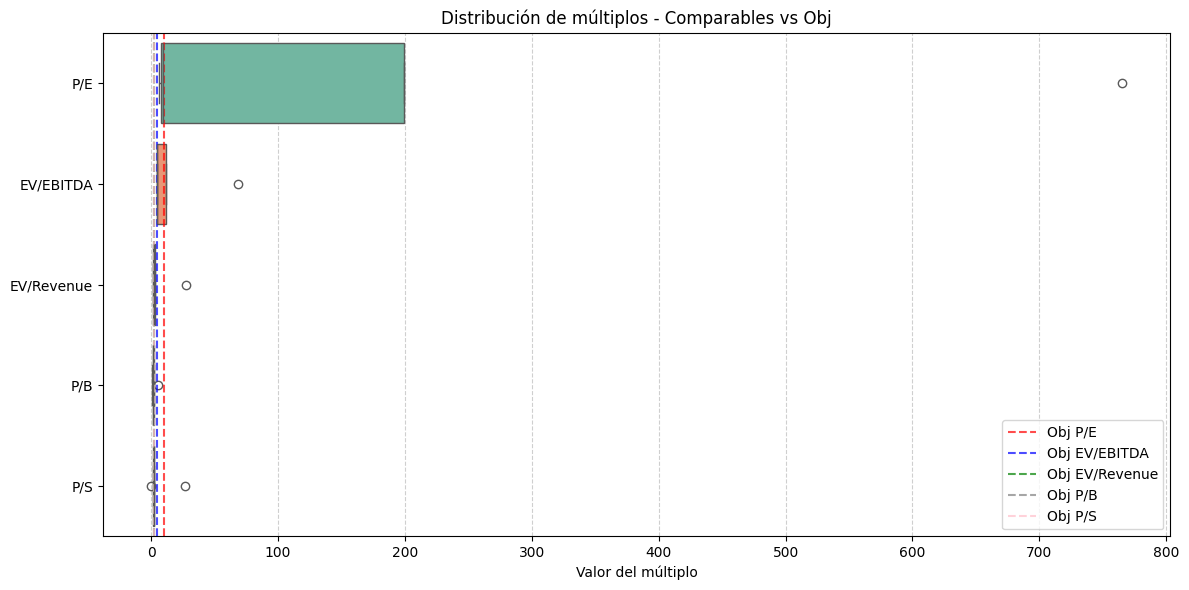

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Dataset para boxplot
data_box = comparables[multiplo_cols].copy()
data_box.loc[ticker] = empresa_obj[multiplo_cols]  # agregamos MSFT para comparar

plt.figure(figsize=(12, 6))
sns.boxplot(data=data_box, orient="h", palette="Set2")
plt.axvline(x=empresa_obj["P/E"], color='red', linestyle='--', label="Obj P/E", alpha=0.7)
plt.axvline(x=empresa_obj["EV/EBITDA"], color='blue', linestyle='--', label="Obj EV/EBITDA", alpha=0.7)
plt.axvline(x=empresa_obj["EV/Revenue"], color='green', linestyle='--', label="Obj EV/Revenue", alpha=0.7)
plt.axvline(x=empresa_obj["P/B"], color='grey', linestyle='--', label="Obj P/B", alpha=0.7)
plt.axvline(x=empresa_obj["P/S"], color='pink', linestyle='--', label="Obj P/S", alpha=0.7)
plt.title("Distribución de múltiplos - Comparables vs Obj")
plt.xlabel("Valor del múltiplo")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
